# Attack attempt, using a cGAN to train D and FGSM to refine D

## Imports

In [1]:
import tensorflow as tf
# tf.enable_eager_execution() # default for TF 2.0

tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow import keras  # Import the tf version of keras.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, \
                                    LeakyReLU, Conv2DTranspose, Reshape
# import keras.backend as K
from tensorflow.keras.datasets import mnist

print('TF', tf.__version__)
print('Keras', keras.__version__)

TF 2.1.0
Keras 2.2.4-tf


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import pickle
from glob import glob
from pprint import pprint

import os.path
import shutil
import math
import random
from copy import copy, deepcopy

In [3]:
# Setting seeds for reproducibility 
# np.random.seed(0)
# tf.random.set_seed(0)

# Enlargen plots
plt.rcParams['figure.figsize'] = [10, 5]

## Parameters

In [4]:
# EASY_MODE: if True, Split Learning NN is used as the Discriminator in the GAN. This is good for testing, but
# bypasses the black-box paradigm! Use with caution
EASY_MODE = False

# Black-box params (optimized for MNIST)
depth = 9
filters = 33
dense = 110
num_classes = 10

# Input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model
input_shape = (target_rows, target_cols, 1)

# Attack params:
attack_params = {
    'our_class': 0,                             # the label indices that we want to preserve (and the data we own)
    'attacker_clients': 5,                      # attacker controls X number of clients and their data
    'attack_classes': [1],                      # the label(s) we want to poison
    'flip_to': [7],                             # must be len(attack_classes) - flips the target label ('1') to new class ('7')
    'batch_size': 25,
    'num_clients': 1000,
    'prime_trigger': 0.00, #0.11                # the D test accuracy that, after which, we will move on from priming
    'prime_first_iteration': True,              # whether to always prime on the first iteration
    'prime_by_ckpt': True,                      # whether to prime manually (False) or by loading a checkpoint file (True)
    'prime_cgan_by_ckpt': False,                # whether to load a pretrained cGAN from default/ or start from scratch (False)
    'attack_trigger': 0.8,                      # the D accuracy (wrt Black-box) that, after which, we will commence an attack
    'd_refinement_batch_num': 3,                # number of batches to refine D with: G -> BB <-> D
    'd_refinement_batch_size': 100,             # number of attack images in each refinement batch: G -> BB <-> D
    'train_dataset': None,                      # attack dataset - fixed in the beginning by choosing the attacking clients
                                                # - this is the only data we have access to throughout the training process
    'attacks_per_train_step': 1,                # how many times to attack per epoch
    'prime_exit_trigger': 1.0,                  # how good D has to be on the current blackbox model to exit priming
    'refine_exit_trigger': 1.0,                 # how good D has to be after refinement*
    'train_bb_every_n_its': 6,                  # only train the BB model while querying if (it % train_bb_every_n_its == 0)
    'cgan_query_every_n_its': 1,                # only query BB with cGAN every N iterations
    'refine_using_fgsm': True,                  # use the uGAN to generate images to refine D with via uG -> BB -> D
    'accumulate_g_queries': True,               # whether to keep uGAN imgs every iteration, or to just use most recent (False)
    'flush_g_queries_every_bb_train': False,    # whether to keep uGAN imgs after new BB is trained, or preserved them (False)
    'reset_g_every_bb_train': False,            # whether to reset G back to init every time we train the BB model
}

# Split Learning training params:
split_training_params = {
    'minibatch_size': None,                     # number of samples to operate on at one time
                                                #  - can vary to optimize computing requirements
                                                #  - if None, will evaluate the client's whole batch regardless of its size
    'apply_gradients_after': 20,                # after averaging the gradients from X clients, we will apply them to the model
    'epochs': 1,                                # number of epochs to train for
    'shuffle_clients': True,                    # whether to shuffle the clients during training
    'eval_batch_size': 256,                     # batch size when evaluating test set (not split by clients),
    'train_dataset': None,                      # training set - indexed by client
    'test_dataset': None,                       # testing set - not batched
    'batch_limit': None,                        # how many batches to train on, maximum, per epoch
    'ckpt_folder': "blackbox_checkpoint",       # folder where to store the checkpoints
    'start_id': 'split_start_model',            # start piece
    'middle_id': 'split_middle_model',          # middle piece
    'end_id': 'split_end_model',                # end piece
    'full_id': 'split_model',                   # full model name
}

# cGAN training params:
cgan_training_params = {
    'minibatch_size': split_training_params['minibatch_size'],
    'extra_depth': 3,                           # number of extra middle layers to put in the D of cGAN
    'start_id': 'd_start_model',                # start piece
    'middle_id': 'd_middle_model',              # middle piece
    'end_id': 'd_end_model',                    # end piece
    'full_id': 'd_model',                       # full model name
    'use_bb_ends': True,                        # whether to share the weights of the start and end piece from the BB model
    'batch_size': 256,                          # number of images to generate from cG at once
    'noise_dim': 100,                           # noise vector for cG
    'epochs': 8,                                # number of epochs to train cGAN
    'use_blackbox': False,                      # if True, copies the Blackbox model into D (easy check)
    'd_ckpt_folder': "discriminator_checkpoint",# folder where to store the d checkpoints
    'bb_ckpt_folder': "blackbox_checkpoint",    # folder where the blackbox default ckpt is kept
    'g_ckpt_folder': "generator_checkpoint",    # folder where to store the g checkpoints
    'batches_per_epoch': 100,                   # number of batches to train on per epoch
    'd_trigger': 0.98,                          # train D if g_accuracy is >= X
    'g_trigger': 1.01,                          # train G if g_accuracy is < X
    'loop_times': 0,                            # number of times to apply softmax -> onehot encoding
    'uncertain_loop_times': 1,                  # number to use in the uncertain_loss used by D
    'softmax_power': 2,                         # number used in softmax -> onehot encoding operation
    'd_reset_percentage': 1.0,                  # reset D if the test d_accuracy dips below X% of the original accuracy
    'early_stop_trigger': 5,                    # stop training early, if g_accuracy has not improved for X epochs
    'stop_sensitivity': 0.02,                   # "no improvement" is when the g_accuracy has not moved more than X% from prev
    'g_nudge_trigger': 3,                       # if "no improvement" for X epochs, turn on D for one turn
    'g_nudge_probability': 0.20,                # probability of nudging this sample, if enabled
    'counter_nudge': True,                      # whether to train an extra epoch when coming out of training right after nudge
    'd_priming_epoch_limit': 1000,              # number of epochs to stop at for priming
    'd_refine_epoch_limit': 500,                # number of epochs to stop at for refining D
    'save_best_g': False,                       # whether to save the best G during training, or to just use the last one
    'd_restore_after_nudge': True,              # whether to restore D back to normal at the end of the epoch if it was nudged
    'reset_g_every_it': False,                  # whether to restore cG back to init at the end of Step 5 if not -> Step 6
}

# FGSM training params:
fgsm_training_params = {
    'epsilon': 0.5,
    'norm': 'L1',                                 # can be L1, Inf
}

# Data parsing params
clients_per_class = 100                         # number of clients per label. Each client only has access to one label
                                                # - each unique class is divided into X number of subsets

# Dataset params
separated_folder = "./separated_dataset"
os.makedirs(separated_folder, exist_ok=True)
separated_train_path = os.path.join(separated_folder, "train_separated.pkl")
separated_test_path = os.path.join(separated_folder, "test_separated.pkl")

In [5]:
# TODO:
# Parameters for Label Poisoning:

attack_params['attacker_clients'] = 95
num_poisoning_iterations = 1

training_classes_to_keep = [0, 1, 2, 3, 4, 5, 6, 8, 9]
# training_classes_to_keep = []

## Load Data

In [6]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255    # range is [0, 1]
x_test /= 255     # range is [0, 1]

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

BUFFER_SIZE = x_train.shape[0]

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [8]:
# Separating the data by class
if os.path.isfile(separated_train_path):
    with open(separated_train_path, 'rb') as f:
        x_train_dict, y_train_dict = pickle.load(f)
        print('loaded training seperation')
else:
    x_train_dict = {}
    y_train_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_train_dict[target_label] = []
        y_train_dict[target_label] = []
        for i, label in enumerate(y_train):
            if list(label).index(1) == target_label:
                x_train_dict[target_label].append(x_train[i])
                y_train_dict[target_label].append(y_train[i])
    
    with open(separated_train_path, 'wb') as f:
        pickle.dump([x_train_dict, y_train_dict], f)
        print('saved training seperation')

if os.path.isfile(separated_test_path):
    with open(separated_test_path, 'rb') as f:
        x_test_dict, y_test_dict = pickle.load(f)
        print('loaded testing seperation')
else:
    x_test_dict = {}
    y_test_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_test_dict[target_label] = []
        y_test_dict[target_label] = []
        for i, label in enumerate(y_test):
            if list(label).index(1) == target_label:
                x_test_dict[target_label].append(x_test[i])
                y_test_dict[target_label].append(y_test[i])

    with open(separated_test_path, 'wb') as f:
        pickle.dump([x_test_dict, y_test_dict], f)
        print('saved testing seperation')
    
# convert dicts to lists
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]

x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

loaded training seperation
loaded testing seperation


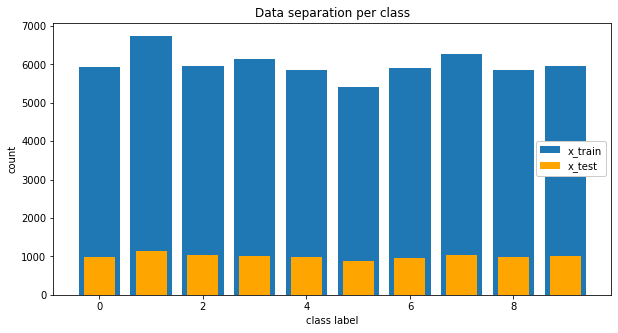

In [9]:
# summary of data shapes:
plt.figure()
plt.title('Data separation per class')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='tab:blue')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='orange', width=0.6)
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

#### Separate the data into batches for clients to use

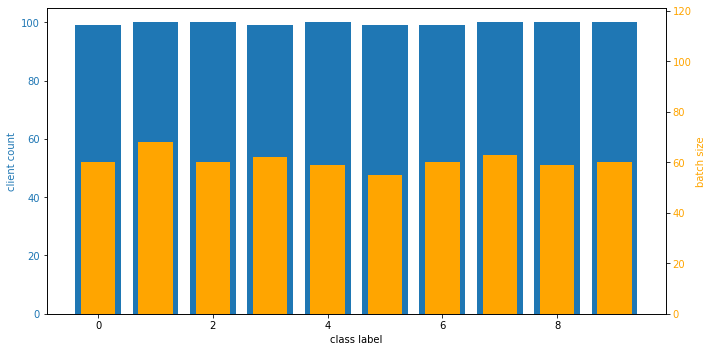

Clients per class:  99.6 ~= 100
Total number of clients: 996
Average batch size: 60.6


In [10]:
# Separate the data into a long list of batches, each batch representing a client training with that batch of images.
# After each batch, a new client will have the opportunity to train their batch of images.
# Batches are shuffled to simulate many clients training the model at once.

client_counts = {}
batch_sizes = {}
x_batches = []
y_batches = []

def ceil(a,b):
    return -(-a//b)

for class_idx in range(len(x_train_seperated)):
    # Get batches from class data:
    n_samples_per_class = len(x_train_seperated[class_idx])
    samples_per_client = n_samples_per_class / clients_per_class
    better_batch_size = int(math.ceil(samples_per_client))

    count = 0
    for i in range(ceil(n_samples_per_class, better_batch_size)):
        x_batches.append((class_idx, x_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        y_batches.append((class_idx, y_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        count += 1
    client_counts[class_idx] = count
    batch_sizes[class_idx] = better_batch_size
        
# double check that the clients_per_class is upheld per class
# (blue bars should be uniform, orange should change according to class):
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('class label')
ax1.set_ylabel('client count', color=color)
plt.bar(client_counts.keys(), [v for v in client_counts.values()], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'orange'
ax2.set_ylabel('batch size', color=color)  # we already handled the x-label with ax1
plt.bar(batch_sizes.keys(), [v for v in batch_sizes.values()], color=color, width=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, np.mean([v for v in batch_sizes.values()])*2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Clients per class:  {} ~= {}'.format(np.mean([v for v in client_counts.values()]), clients_per_class))
print('Total number of clients: {}'.format(np.sum([v for v in client_counts.values()])))
print('Average batch size: {}'.format(np.mean([v for v in batch_sizes.values()])))

split_batch_size = np.floor(np.mean([v for v in batch_sizes.values()]))

#### Define the attacker's dataset

In [11]:
x_batches_filtered_i = [i for i, batch in enumerate(x_batches) if batch[0] == attack_params['our_class']]
y_batches_filtered_i = [i for i, batch in enumerate(y_batches) if batch[0] == attack_params['our_class']]
assert x_batches_filtered_i == y_batches_filtered_i

x_batches_filtered = list(map(x_batches.__getitem__, x_batches_filtered_i))
y_batches_filtered = list(map(y_batches.__getitem__, y_batches_filtered_i))

print('{} clients to choose from:'.format(len(x_batches_filtered)))
print('Classes of attack clients:', [f[0] for f in x_batches_filtered])
print()

attack_clients = np.random.choice(len(x_batches_filtered), attack_params['attacker_clients'], replace=False)
print('Choosing the following clients as the attackers:\n{}'.format(attack_clients))
x_attack_batches = list(map(x_batches_filtered.__getitem__, attack_clients))
y_attack_batches = list(map(y_batches_filtered.__getitem__, attack_clients))

99 clients to choose from:
Classes of attack clients: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Choosing the following clients as the attackers:
[85 75 42 19 20 38 55 30 44 93 70 76 51  7 91 58 14 43 37 79 60 24 10 90
 21 15 25 33 16 81 56  3 40 52  4  2 47 80 26 22 72 27 95 83  8 41 45 64
 49  5 13 74 54 71 53 63 39 11 62 32  6 92 98 12 78 50 36 67 66  9 94 89
 29  1 84 82 59 69 17 87 77 96 88 46 65 73  0 18 97 35 31 68 57 48 34]


In [12]:
# remove the attackers from the original training dataset
# BREAKS THE ORIGINAL X_BATCHES AND Y_BATCHES!
print('Original dataset length:', len(x_batches), len(y_batches))

x_attackers_i = list(map(x_batches_filtered_i.__getitem__, attack_clients))
y_attackers_i = list(map(y_batches_filtered_i.__getitem__, attack_clients))

x_batches = [batch for i, batch in enumerate(x_batches) if i not in x_attackers_i]
y_batches = [batch for i, batch in enumerate(y_batches) if i not in y_attackers_i]

print('New dataset length:     ', len(x_batches), len(y_batches))

Original dataset length: 996 996
New dataset length:      901 901


#### Define our datasets

In [13]:
# Batch and shuffle the data for Split Learning
split_train_dataset = (x_batches, y_batches)
split_test_dataset = (x_test, y_test)

# place into train params:
split_training_params['train_dataset'] = split_train_dataset
split_training_params['test_dataset'] = split_test_dataset

# Build attack dataset
attack_train_dataset = (x_attack_batches, y_attack_batches)
attack_params['train_dataset'] = attack_train_dataset

In [14]:
# Show min and max of the dataset (ensure you are using the right normalization)
min_ = np.inf
max_ = -np.inf
for batch in x_batches:
    min__ = np.min(batch[1])
    max__ = np.max(batch[1])
    min_ = min(min_, min__)
    max_ = max(max_, max__)
print('Min: {}; Max: {}'.format(min_, max_))

Min: 0.0; Max: 1.0


## Build Model

In [15]:
# FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=

def start_piece(identifier, input_shape, filters=4):
    assert filters >= 1
    
    input_1 = keras.layers.Input(input_shape)
    conv1 = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(input_1)
    model = keras.models.Model(inputs=[input_1], outputs=conv1)
    model._name = identifier
    
    return model

def blackbox_piece(identifier, input_shape, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    input_2 = keras.layers.Input(input_shape)
    
    # for now, we will just give the black-box all the CNN layers
    for i in range(depth-1):
        if i == 0:
            convs = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(input_2)
        else:
            convs = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(convs)
            
    model = keras.models.Model(inputs=[input_2], outputs=convs)
    model._name = identifier
    
    return model

def approximator_piece(identifier, input_shape, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    input_2 = keras.layers.Input(input_shape)
    
    # for now, we will just give the black-box all the CNN layers
    for i in range(depth-1):
        if i == 0:
            convs = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(input_2)
        else:
            convs = Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same')(convs)
            
    model = keras.models.Model(inputs=[input_2], outputs=convs)
    model._name = identifier
    
    return model

def end_piece(identifier, input_shape, dense_breadth=128, num_classes=10):
    assert dense_breadth >= num_classes
    
    input_3 = keras.layers.Input(input_shape)
    
    pool1 = MaxPooling2D(pool_size=(2, 2))(input_3)
    drop1 = Dropout(0.25)(pool1)
    flat1 = Flatten()(drop1)
    dense1 = Dense(dense_breadth, activation='relu')(flat1)
    drop2 = Dropout(0.5)(dense1)
    dense2 = Dense(num_classes, activation='softmax')(drop2)
    
    model = keras.models.Model(inputs=[input_3], outputs=dense2)
    model._name = identifier
    
    return model

## Graph Creation

In [16]:
# Ensure the params are acceptable:
assert depth >= 1
assert filters >= 1
assert dense >= num_classes

In [17]:
class SplitLearning:
    
    def __init__(self, split_training_params):
        self.minibatch_size = split_training_params['minibatch_size']
        self.batches_per_train_step = split_training_params['apply_gradients_after']
        self.eval_batch_size = split_training_params['eval_batch_size']
        self.shuffle_clients = split_training_params['shuffle_clients']
        
        self.ckpt_folder = split_training_params['ckpt_folder']
        self.start_id = split_training_params['start_id']
        self.middle_id = split_training_params['middle_id']
        self.end_id = split_training_params['end_id']
        self.full_id = split_training_params['full_id']
        
        # define the NN model
        self.start_piece = None
        self.middle_piece = None
        self.end_piece = None
        self.model = self.blackbox_model()
        
        # define loss function
        self.cross_entropy = keras.losses.CategoricalCrossentropy(from_logits=True)
        
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # define metrics
        self.acc_train_avg = None
        self.loss_train_avg = None
        
        # setup checkpointing
        self.init_ckpt()
        
        # setup ops
        self.setup_ops()
        
    ###########################################################################################
    # Black-box model
        
    def blackbox_model(self):
        # create all three models
        
        #   start piece...
        self.start_piece = start_piece(self.start_id, input_shape, filters)
        output_shape = self.start_piece.layers[-1].output_shape[1:]
        
        #   middle...
        self.middle_piece = blackbox_piece(self.middle_id, output_shape, depth, filters)
        output_shape = self.middle_piece.layers[-1].output_shape[1:]
        
        #   end piece...
        self.end_piece = end_piece(self.end_id, output_shape, dense, num_classes)
        
        # glue the three models together
        input_ = keras.layers.Input(input_shape)
        hidden1 = self.start_piece(input_)
        hidden2 = self.middle_piece(hidden1)
        output_ = self.end_piece(hidden2)
        
        # create the full model
        model = keras.models.Model(inputs=[input_], outputs=output_)
        model._name = self.full_id
        model.summary()
        
        return model
    
    def model_loss(self, y_true, y_pred):
        return self.cross_entropy(y_true, y_pred)
        
    ###########################################################################################
    # Train
    
    def setup_ops(self):
        # INSPIRED BY: https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients
        # https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
        
        self.tvs = self.model.trainable_variables
        self.accum_vars = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in self.tvs]
        self.accum_counter = tf.Variable(0.0, trainable=False)
    
    def train(self, datasets, iteration, g_dataset=None, batch_limit=None, attack_datasets=None):
        # setup checkpointing
        self.setup_ckpt(iteration)
        
        # setup bb_dataset (stores labels if g_dataset is passed in)
        bb_dataset = []
        
        g_dataset_acc = tf.keras.metrics.Accuracy()
        
        # initialize the metrics each new epoch
        if self.acc_train_avg is not None:
            del self.acc_train_avg
        if self.loss_train_avg is not None:
            del self.loss_train_avg
        self.acc_train_avg = tf.keras.metrics.Accuracy()
        self.loss_train_avg = tf.keras.metrics.Mean()
        
        # append all datasets together for training:
        x_batches = []
        y_batches = []
        for dataset in datasets:
            x_batches_, y_batches_ = dataset
            x_batches = x_batches + x_batches_
            y_batches = y_batches + y_batches_
        # if g_dataset is not None, add those batches to the end:
        if g_dataset is not None:
            g_x_batches, g_y_batches = g_dataset
            g_batch_idxs = list(range(len(x_batches), len(x_batches)+len(g_x_batches)))
            x_batches = x_batches + g_x_batches
            y_batches = y_batches + g_y_batches
        else:
            g_batch_idxs = []
            
        # do the same thing with the attack datasets
        if attack_datasets is None:
            attack_datasets = []
        x_attack = []
        y_attack = []
        for dataset in attack_datasets:
            x_attack_, y_attack_ = dataset
            x_attack = x_attack + x_attack_
            y_attack = y_attack + y_attack_
            
#         print(len_x_attack)
#         print(len_x_attack[0])
#         print(len_x_attack[0][1])
            
        # setup progress bar
        total_batches = batch_limit if batch_limit is not None and batch_limit < len(x_batches) else len(x_batches)
        pbar = tqdm_notebook(total=total_batches)
        
        batch_idxs = list(range(len(x_batches)))
        if self.shuffle_clients:
            # shuffle the batches each time
            random.shuffle(batch_idxs)
            
        for i, batch_idx in enumerate(batch_idxs):
            x_batch = x_batches[batch_idx][1]
            y_batch = y_batches[batch_idx][1]
            
            if batch_idx in g_batch_idxs:
                # this is a g_x_batch! don't apply gradients, but store the prediction
                logit_batch = self.pred_step(x_batch)
                g_dataset_acc(tf.argmax(y_batch, 1), tf.argmax(logit_batch, 1))
                bb_dataset.append((x_batch, y_batch, logit_batch))
            else:
                self.train_step(i, x_batch, y_batch, len(batch_idxs) - 1, attack=(x_attack, y_attack))
            pbar.update(1)
            pbar.set_description('train_acc={:.2f}%'.format(self.acc_train_avg.result()*100))
            
            if batch_limit is not None and i-1 >= batch_limit:
                break
        pbar.close()
        print('train_acc={:.4f}%'.format(self.acc_train_avg.result()*100))
        print('accuracy of blackbox on G dataset: {:.4f}%'.format(g_dataset_acc.result()*100))
        
        # save checkpoints
        self.checkpoint()
        
        return bb_dataset
        
    def pred_step(self, x_batch):
        logit_batch = []
        # Iterate over the client's batch in minibatches:
        j = 0
        while(j < len(x_batch)):
            if self.minibatch_size is None:
                # use whole batch (no minibatch)
                x_minibatch = x_batch
            else:
                x_minibatch = x_batch[j:(j+self.minibatch_size)]

            logits = self.model(x_minibatch, training=True) # TODO: should this be False?
            logit_batch = logit_batch + list(logits.numpy())

            if self.minibatch_size is None:
                break
            else:
                j += self.minibatch_size
                
        return logit_batch
        
    def train_step(self, i, x_batch, y_batch, limit, attack=None):
        # Iterate over the client's batch in minibatches:
        j = 0
        while(j < len(x_batch)):
            if self.minibatch_size is None:
                # use whole batch (no minibatch)
                x_minibatch = x_batch
                y_minibatch = y_batch
            else:
                x_minibatch = x_batch[j:(j+self.minibatch_size)]
                y_minibatch = y_batch[j:(j+self.minibatch_size)]

            # run the gradients
            loss_value, grads = self.grad(x_minibatch, y_minibatch)

            # accumulate them
            self.accumulate_grads(grads)

            if self.minibatch_size is None:
                break
            else:
                j += self.minibatch_size

        # perform a train step every batches_per_train_step number of batches:
        if (i > 0 and i % self.batches_per_train_step == 0) or i == limit:
            
            if attack is not None and len(attack[0]) > 0:
                x_batches = attack[0]
                y_batches = attack[1]
                
                for b in range(len(x_batches)):
                    x_batch = x_batches[b][1]
                    y_batch = y_batches[b][1]
                
                    for i in range(attack_params['attacks_per_train_step']):
                        ##########
                        # Add attack to the grads X number of times:
                        j = 0
                        while(j < len(x_batch)):
                            if self.minibatch_size is None:
                                # use whole batch (no minibatch)
                                x_minibatch = x_batch
                                y_minibatch = y_batch
                            else:
                                x_minibatch = x_batch[j:(j+self.minibatch_size)]
                                y_minibatch = y_batch[j:(j+self.minibatch_size)]

                            # run the gradients
                            loss_value, grads = self.grad(x_minibatch, y_minibatch)

                            # accumulate them
                            self.accumulate_grads(grads, num_times=attack_params['num_clients'])

                            if self.minibatch_size is None:
                                break
                            else:
                                j += self.minibatch_size
                        ##########
            
            # Run the train_step ops to update the weights based on our accumulated gradients
            self.optimize()
            self.zero_out()
    
    def grad(self, inputs, targets):
        with tf.GradientTape() as tape:
            logits = self.model(inputs, training=True)
            loss_value = self.model_loss(targets, logits)
            
        # evaluate accuracy and append acc and loss to arrays
        self.acc_train_avg(tf.argmax(targets, 1), tf.argmax(logits, 1))
        self.loss_train_avg(loss_value)
        
        return loss_value, tape.gradient(loss_value, self.model.trainable_variables)
    
    def accumulate_grads(self, grads, num_times=1):
        # add to accum_vars the new gradients
        for i, grad in enumerate(grads):
            self.accum_vars[i].assign_add(grad * num_times)
        # increment the counter by 1
        self.accum_counter.assign_add(1.0 * num_times)
        
    def optimize(self):
        # apply the gradients in accum_vars, dividing by the number in accum_counter
        self.optimizer.apply_gradients(
            [(accum_var / self.accum_counter, tv) \
                for (accum_var, tv) in zip(self.accum_vars, self.model.trainable_variables)]
        )
    
    def zero_out(self):
        # reset accum_vars and accum_counter back to 0
        for i, tv in enumerate(self.accum_vars):
            self.accum_vars[i].assign(tf.zeros_like(tv))
        self.accum_counter = tf.Variable(0.0, trainable=False)
        
    ###########################################################################################
    # Checkpoint
    
    def init_ckpt(self):
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        self.manager = None
        self.internal_iteration = None
        self.iteration_offset = 0
        
    def setup_ckpt(self, iteration):
        # setup fresh checkpointer every new iteration
        if self.internal_iteration is None or iteration != self.internal_iteration - self.iteration_offset:
            ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration + self.iteration_offset), self.ckpt_folder)
            os.makedirs(ckpt_save_folder, exist_ok=True)
        
            if self.ckpt is not None:
                del self.ckpt
            if self.manager is not None:
                del self.manager

            self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
            self.manager = tf.train.CheckpointManager(self.ckpt, ckpt_save_folder, max_to_keep=1)
            self.internal_iteration = iteration + self.iteration_offset
    
    def checkpoint(self):
        save_path = self.manager.save()
        print("Saved checkpoint: {}".format(save_path))
        self.save_all_models(save_path)
        
    def save_all_models(self, save_path):
        # in addition to checkpointing, save all of the models into their own ckpt files
        it_folder = ""
        for folder in self.splitall(save_path):
            if "it" not in folder:
                it_folder = os.path.join(it_folder, folder)
            else:
                it_folder = os.path.join(it_folder, folder)
                break
        
        # save all three models
        start_piece_folder = os.path.join(it_folder, self.start_id + "_checkpoint")
        os.makedirs(start_piece_folder, exist_ok=True)
        self.start_piece.save_weights(os.path.join(start_piece_folder, 'checkpoint'))
        print("Saved checkpoint: {}".format(os.path.join(start_piece_folder, 'checkpoint')))
        
        middle_piece_folder = os.path.join(it_folder, self.middle_id + "_checkpoint")
        os.makedirs(middle_piece_folder, exist_ok=True)
        self.middle_piece.save_weights(os.path.join(middle_piece_folder, 'checkpoint'))
        print("Saved checkpoint: {}".format(os.path.join(middle_piece_folder, 'checkpoint')))
        
        end_piece_folder = os.path.join(it_folder, self.end_id + "_checkpoint")
        os.makedirs(end_piece_folder, exist_ok=True)
        self.end_piece.save_weights(os.path.join(end_piece_folder, 'checkpoint'))
        print("Saved checkpoint: {}".format(os.path.join(end_piece_folder, 'checkpoint')))
        
    @staticmethod
    def splitall(path):
        allparts = []
        while 1:
            parts = os.path.split(path)
            if parts[0] == path:  # sentinel for absolute paths
                allparts.insert(0, parts[0])
                break
            elif parts[1] == path: # sentinel for relative paths
                allparts.insert(0, parts[1])
                break
            else:
                path = parts[0]
                allparts.insert(0, parts[1])
        return allparts
        
    def restore(self, it_restore=None, load_default=False, checkpoint_folder='checkpoints'):
        parent_folder = os.path.join(checkpoint_folder)
        if it_restore is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, self.ckpt_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    if '_' in d:
                        # passed, valid iteration folder
                        it = int(d.split('_')[1])
                        if largest_it is None or it > largest_it:
                            largest_it = it
            if largest_it is not None:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), self.ckpt_folder)
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                self.iteration_offset = largest_it
                print('Restored latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found, starting with a fresh network')
        else:
            if load_default:
                checkpoint_directory = os.path.join(parent_folder, 'default', self.ckpt_folder)
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it_restore), self.ckpt_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                if it_restore is not None:
                    self.iteration_offset = it_restore
                print('Restored latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        
    ###########################################################################################
    # Evaluate
        
    def evaluate(self, dataset):
        '''
        NOTE: dataset here is tailored for standard 'test' dataset provided by Keras
        '''
        
        x, y = dataset
        
        acc_test_avg = tf.keras.metrics.Accuracy()
        loss_test_avg = tf.keras.metrics.Mean()
        for i in range(0, len(x), self.eval_batch_size):
            # get batch
            x_batch = x[i:i+self.eval_batch_size]
            y_batch = y[i:i+self.eval_batch_size]
            
            # evaluate
            logits = self.model(x_batch, training=False)
            acc_test_avg(tf.argmax(y_batch, 1), tf.argmax(logits, 1))
            loss_test_avg(self.model_loss(y_batch, logits))
        
        if self.acc_train_avg is not None and self.loss_train_avg is not None:
            print('Train Accuracy: {:.3f} | Loss: {:.3f}'.format(self.acc_train_avg.result(), self.loss_train_avg.result()))
        print('Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test_avg.result(), loss_test_avg.result()))
        print()
        
    def predict(self, dataset, return_tensors=True):
        '''
        Returns a list of label batches of each client that was in the dataset
        '''
        
        x, _ = dataset
        labels = []
        
        for i, client_x in enumerate(x):
            x_batch = client_x[1]
            label_batch = []
            
            # run through every minibatch:
            j = 0
            while(j < len(x_batch)):
                if self.minibatch_size is None:
                    # use whole batch (no minibatch)
                    x_minibatch = x_batch
                else:
                    x_minibatch = x_batch[j:(j+self.minibatch_size)]
                    
                # evaluate
                preds = self.model(x_batch, training=False)
                if not return_tensors:
                    preds = tf.nn.softmax(preds)
                    preds = tf.argmax(preds, axis=1)
                    
                label_batch = label_batch + list(preds.numpy())
                
                if self.minibatch_size is None:
                    break
                else:
                    j += self.minibatch_size
            
            # add to list
            labels.append(label_batch)
            
        return labels

In [18]:
class D:
    '''
    The Discriminator portion of the GAN. Accepts a network, otherwise creates a new model.
    '''
    
    def __init__(self, gan_training_params, start_piece=None, middle_piece=None, end_piece=None, d_model=None):
        
#         self.ckpt_folder = gan_training_params['d_ckpt_folder']
        self.ckpt_folder = gan_training_params['middle_id']
        self.bb_ckpt_folder = gan_training_params['bb_ckpt_folder']
        self.loop_times = gan_training_params['loop_times']
        self.softmax_power = gan_training_params['softmax_power']
        self.minibatch_size = gan_training_params['minibatch_size']
        
        self.use_bb_ends = gan_training_params['use_bb_ends']
        self.start_id = gan_training_params['start_id']
        self.middle_id = gan_training_params['middle_id']
        self.end_id = gan_training_params['end_id']
        self.full_id = gan_training_params['full_id']
        
        # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
        
        # define the NN model
        if d_model is not None:
            assert start_piece is None and middle_piece is None and end_piece is None
            self.model = d_model
        else:
            self.start_piece = start_piece
            self.middle_piece = middle_piece
            self.end_piece = end_piece
            self.model = self.discriminator_model()
            
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # define entropies
        self.cat_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.bin_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            
        # setup checkpointing
        self.ckpt = None
        self.manager = None
        
        # save the initial weights
        if middle_piece is None:
            self.save_initial_weights()
        
    ###########################################################################################
    # Discriminator model
    
    def discriminator_model(self):
        # create all three models
        
        #   start piece...
        if self.use_bb_ends:
            assert self.start_piece is not None
        else:
            self.start_piece = start_piece(self.start_id, input_shape, filters)
        output_shape = self.start_piece.layers[-1].output_shape[1:]
        
        #   middle...
        if self.middle_piece is None:
            self.middle_piece = approximator_piece(self.middle_id, output_shape, depth, filters)
        else:
            print('WARNING: using the middle piece in D')
        output_shape = self.middle_piece.layers[-1].output_shape[1:]
        
        #   end piece...
        if self.use_bb_ends:
            assert self.end_piece is not None
        else:
            self.end_piece = end_piece(self.end_id, output_shape, dense, num_classes)
        
        # glue the three models together
        input_ = keras.layers.Input(input_shape)
        hidden1 = self.start_piece(input_)
        hidden2 = self.middle_piece(hidden1)
        output_ = self.end_piece(hidden2)
        
        # create the full model
        model = keras.models.Model(inputs=[input_], outputs=output_)
        model._name = self.full_id
        model.summary()
        
        return model
        
    ###########################################################################################
    # Loss
    
    def loss(self, fake_discrimination, labels):
        matches = self.matches_labels(fake_discrimination, labels, loop_times=self.loop_times)
        # we want the discriminator to NOT be fooled by these fake images
        cross_entropy = self.bin_cross_entropy(tf.zeros_like(matches), matches)
        return cross_entropy
    
    def entropy(self, y_true, y_pred):
        return self.cat_cross_entropy(y_true, y_pred)
        
    def matches_labels(self, fake_output, labels, loop_times=0):
        '''
        Only works if the Discriminator is already trained on real images!!
        1. Performs a softmax -> onehot conversion (differentiable approx.)
        2. Multiplies this by the onehot version of the onehot attack label
        3. Sums to reduce dimension
        
        - if the sum is close to 1, the nn thinks that the image is a part of the attack class
        - if the sum is close to 0, the nn thinks that the image is not of the attack class
        - the sum should not be in between, due to the onehot conversion we perform in step 1
        '''
        # 1.
        my_power = self.softmax_power
        for i in range(loop_times):
            fake_output = self.soft_onehot(fake_output)
        
        # 2.
        matches = tf.math.multiply(fake_output, labels)
        
        # 3.
        reduced = tf.math.reduce_sum(matches, axis=-1)
        
        return reduced
        
    def soft_onehot(self, softmax, my_power=8):
        '''
        Shown to not really work... vanishing gradients problem
        '''
        soft_extreme = softmax ** my_power
        norm = tf.reduce_sum(soft_extreme, axis=-1)
        almost_onehot = tf.math.divide(soft_extreme, tf.reshape(norm, (-1, 1)))
        return almost_onehot
    
    ###########################################################################################
    # Checkpoint
    
    def init_ckpt(self):
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        
    def setup_ckpt(self, iteration):
        ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration), self.ckpt_folder)
        os.makedirs(ckpt_save_folder, exist_ok=True)

        if self.ckpt is not None:
            del self.ckpt
        if self.manager is not None:
            del self.manager

        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.middle_piece)
        self.manager = tf.train.CheckpointManager(self.ckpt, ckpt_save_folder, max_to_keep=1)
        
    def checkpoint(self):
        save_path = self.manager.save()
        print("Saved D checkpoint: {}".format(save_path))
        self.save_all_models(save_path)
        
    def save_all_models(self, save_path):
        # in addition to checkpointing, save all of the models into their own ckpt files
        it_folder = ""
        for folder in self.splitall(save_path):
            if "it" not in folder:
                it_folder = os.path.join(it_folder, folder)
            else:
                it_folder = os.path.join(it_folder, folder)
                break
        
        # save all three models
        start_piece_folder = os.path.join(it_folder, self.start_id + "_checkpoint")
        os.makedirs(start_piece_folder, exist_ok=True)
        self.start_piece.save_weights(os.path.join(start_piece_folder, 'checkpoint'))
        print("Saved D checkpoint: {}".format(os.path.join(start_piece_folder, 'checkpoint')))
        
        middle_piece_folder = os.path.join(it_folder, self.middle_id + "_checkpoint")
        os.makedirs(middle_piece_folder, exist_ok=True)
        self.middle_piece.save_weights(os.path.join(middle_piece_folder, 'checkpoint'))
        print("Saved D checkpoint: {}".format(os.path.join(middle_piece_folder, 'checkpoint')))
        
        end_piece_folder = os.path.join(it_folder, self.end_id + "_checkpoint")
        os.makedirs(end_piece_folder, exist_ok=True)
        self.end_piece.save_weights(os.path.join(end_piece_folder, 'checkpoint'))
        print("Saved D checkpoint: {}".format(os.path.join(end_piece_folder, 'checkpoint')))
        
    @staticmethod
    def splitall(path):
        allparts = []
        while 1:
            parts = os.path.split(path)
            if parts[0] == path:  # sentinel for absolute paths
                allparts.insert(0, parts[0])
                break
            elif parts[1] == path: # sentinel for relative paths
                allparts.insert(0, parts[1])
                break
            else:
                path = parts[0]
                allparts.insert(0, parts[1])
        return allparts
    
    def freeze_ends(self, yes):
        self.start_piece.is_training = not yes
        self.end_piece.is_training = not yes
    
    ###########################################################################################
    # Load/save weights
    
    def save_initial_weights(self):
        print('saving initial weights for D')
        init_folder = os.path.join('checkpoints', 'init', self.ckpt_folder)
        os.makedirs(init_folder, exist_ok=True)
        self.model.save_weights(os.path.join(init_folder, 'checkpoint'))
        
    def load_initial_weights(self):
        print('loading initial weights for D')
        init_folder = os.path.join('checkpoints', 'init', self.ckpt_folder)
        self.model.load_weights(os.path.join(init_folder, 'checkpoint'))
        
    def restore(self, it_restore=None, load_default=False, use_blackbox=False, checkpoint_folder='checkpoints'):
        parent_folder = os.path.join(checkpoint_folder)
        iteration_offset = 0
        if it_restore is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, self.ckpt_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    if '_' in d:
                        # passed, valid iteration folder
                        it = int(d.split('_')[1])
                        if largest_it is None or it > largest_it:
                            largest_it = it
            if largest_it is not None:
#                 checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), self.ckpt_folder)
#                 self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                self.restore_pieces(it_restore_ends=largest_it, it_restore_middle=largest_it)
                iteration_offset = largest_it
#                 print('Restored D to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found for D, starting with a fresh network')
        else:
            if load_default:
                if use_blackbox:
                    checkpoint_directory = os.path.join(parent_folder, 'default', self.bb_ckpt_folder)
                else:
                    checkpoint_directory = os.path.join(parent_folder, 'default', self.ckpt_folder)
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it_restore), self.ckpt_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                if it_restore is not None:
                    iteration_offset = it_restore
                print('Restored D to checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        return iteration_offset
    
    def restore_middle(self, it_restore_middle, checkpoint_folder='checkpoints'):
        parent_folder = os.path.join(checkpoint_folder)
        it_folder_middle = os.path.join(parent_folder, 'it_{}'.format(it_restore_middle))
        middle_piece_folder = os.path.join(it_folder_middle, self.middle_id + "_checkpoint")
        print('Restoring D piece: {}'.format(middle_piece_folder))
        
        assert os.path.isfile(os.path.join(middle_piece_folder, 'checkpoint'))
        self.middle_piece.load_weights(os.path.join(middle_piece_folder, 'checkpoint'))
    
    def restore_pieces(self, it_restore_ends=None, it_restore_middle=None, start_id=None, middle_id=None, 
                       end_id=None, load_default=False, checkpoint_folder='checkpoints'):
        
        if it_restore_ends is None:
            it_restore_ends = 1
        if it_restore_middle is None:
            it_restore_middle = 1
        
        if start_id is None:
            start_id = self.start_id
        if middle_id is None:
            middle_id = self.middle_id
        if end_id is None:
            end_id = self.end_id
        
        parent_folder = os.path.join(checkpoint_folder)
        it_folder_ends = os.path.join(parent_folder, 'default' if load_default else 'it_{}'.format(it_restore_ends))
        it_folder_middle = os.path.join(parent_folder, 'default' if load_default else 'it_{}'.format(it_restore_middle))
        
        start_piece_folder = os.path.join(it_folder_ends, start_id + "_checkpoint")
        print('Restoring D piece: {}'.format(start_piece_folder))
        middle_piece_folder = os.path.join(it_folder_middle, middle_id + "_checkpoint")
        print('Restoring D piece: {}'.format(middle_piece_folder))
        end_piece_folder = os.path.join(it_folder_ends, end_id + "_checkpoint")
        print('Restoring D piece: {}'.format(end_piece_folder))
        
        assert os.path.isfile(os.path.join(start_piece_folder, 'checkpoint'))
        assert os.path.isfile(os.path.join(middle_piece_folder, 'checkpoint'))
        assert os.path.isfile(os.path.join(end_piece_folder, 'checkpoint'))
        
        self.start_piece.load_weights(os.path.join(start_piece_folder, 'checkpoint'))
        self.middle_piece.load_weights(os.path.join(middle_piece_folder, 'checkpoint'))
        self.end_piece.load_weights(os.path.join(end_piece_folder, 'checkpoint'))
        
    ###########################################################################################
    # Evaluation

    def discriminate(self, generated_images, training=True):
        return self.model(generated_images, training=training)

In [19]:
class G:
    '''
    The Generator portion of the GAN. Generates images given a conditional label.
    '''
    
    def __init__(self, gan_training_params, is_conditional=True, identifier=None, extra_depth=0):
        self.is_conditional = is_conditional
        self.identifier = identifier
        
        self.ckpt_folder = self.g_identifier() + gan_training_params['g_ckpt_folder']
        self.noise_dim = gan_training_params['noise_dim']
        self.uncertain_loop_times = gan_training_params['uncertain_loop_times']
        self.softmax_power = gan_training_params['softmax_power']
        
        # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
        self.input_shapes = []
        if is_conditional:
            self.model = self.c_generator_model(extra_depth)
        else:
            self.model = self.u_generator_model()
            
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # define entropies
        self.cat_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.bin_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            
        # setup checkpointing
        self.ckpt = None
        self.manager = None
        
        # save initial weights
        self.save_initial_weights()
        
    ###########################################################################################
    # Generator model
    
    def g_identifier(self):
        return self.identifier if self.identifier is not None else ''
    
    def c_generator_model(self, extra_depth=0):
        '''
        CONDITIONAL version of G
        '''
        ACTIVATION = keras.layers.Activation("tanh")
        
        # Prepare noise input
        self.input_shapes.append((self.noise_dim,))
        input_z = keras.layers.Input((self.noise_dim,))
        dense_z_1 = keras.layers.Dense(1024)(input_z)
        act_z_1 = ACTIVATION(dense_z_1)
        dense_z_2 = keras.layers.Dense(128 * 7 * 7)(act_z_1)
        bn_z_1 = keras.layers.BatchNormalization()(dense_z_2)
        reshape_z = keras.layers.Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_z_1)

        # Prepare Conditional (label) input
        self.input_shapes.append((num_classes,))
        input_c = keras.layers.Input((num_classes,))
        dense_c_1 = keras.layers.Dense(1024)(input_c)
        act_c_1 = ACTIVATION(dense_c_1)
        dense_c_2 = keras.layers.Dense(128 * 7 * 7)(act_c_1)
        bn_c_1 = keras.layers.BatchNormalization()(dense_c_2)
        reshape_c = keras.layers.Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_c_1)

        # Combine input source
        concat_z_c = keras.layers.Concatenate()([reshape_z, reshape_c])

        # Image generation with the concatenated inputs
        up_1 = keras.layers.UpSampling2D(size=(2, 2))(concat_z_c)
        conv_1 = keras.layers.Conv2D(64, (5, 5), padding='same')(up_1)
        for i in range(extra_depth):
            conv_1 = keras.layers.Conv2D(64, (5, 5), padding='same')(conv_1)
        act_1 = ACTIVATION(conv_1)
        up_2 = keras.layers.UpSampling2D(size=(2, 2))(act_1)
        #
        drop_1 = keras.layers.Dropout(0.1)(up_2)
        #
        conv_2 = keras.layers.Conv2D(1, (5, 5), padding='same')(drop_1)
        act_2 = keras.layers.Activation("tanh")(conv_2)
        model = keras.models.Model(inputs=[input_z, input_c], outputs=act_2)
        model._name = "{}g_model".format(self.g_identifier())
        return model
    
    def u_generator_model(self):
        '''
        NORMAL version of G
        '''
        model = tf.keras.Sequential()
        
        self.input_shapes.append((self.noise_dim,))
        model.add(Dense(7*7*256, use_bias=False, input_shape=(self.noise_dim,)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Reshape((7, 7, 256)))

        model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
        model.add(BatchNormalization())
        model.add(LeakyReLU())

        model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
        model._name = "{}g_model".format(self.g_identifier())

        return model
        
    ###########################################################################################
    # Loss
    
    def loss(self, fake_discrimination, labels):
        # we want the discriminator to be fooled by these fake images
        cross_entropy = self.cat_cross_entropy(fake_discrimination, labels)
        return cross_entropy
    
    def u_loss(self, fake_discrimination):
        '''
        Loss that measures how close the output is to having a single peak.
        In other words we are measuring how certain the model thinks it is
        correct, regardless of the answer
        1. Performs a softmax -> onehot conversion (differentiable approx.)
        2. Compare to the original output -- return this cat crossentropy
        '''
        fake_output = tf.identity(fake_discrimination)
        
        # 1.
        my_power = self.softmax_power
        for i in range(self.uncertain_loop_times):
            fake_output = self.soft_onehot(fake_output)
            
        # 2.
        return self.cat_cross_entropy(fake_output, fake_discrimination)
        
    def soft_onehot(self, softmax, my_power=8):
        '''
        Shown to not really work... vanishing gradients problem
        '''
        soft_extreme = softmax ** my_power
        norm = tf.reduce_sum(soft_extreme, axis=-1)
        almost_onehot = tf.math.divide(soft_extreme, tf.reshape(norm, (-1, 1)))
        return almost_onehot
    
    ###########################################################################################
    # Checkpoint
    
    def init_ckpt(self):
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        
    def setup_ckpt(self, iteration):
        ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration), self.ckpt_folder)
        os.makedirs(ckpt_save_folder, exist_ok=True)

        if self.ckpt is not None:
            del self.ckpt
        if self.manager is not None:
            del self.manager

        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        self.manager = tf.train.CheckpointManager(self.ckpt, ckpt_save_folder, max_to_keep=1)
        
    def checkpoint(self):
        save_path = self.manager.save()
        print("Saved {}G checkpoint: {}".format(self.g_identifier(), save_path))
    
    ###########################################################################################
    # Load/save weights
    
    def save_initial_weights(self):
        print('saving initial weights for {}G'.format(self.g_identifier()))
        init_folder = os.path.join('checkpoints', 'init', self.ckpt_folder)
        os.makedirs(init_folder, exist_ok=True)
        self.model.save_weights(os.path.join(init_folder, 'checkpoint'))
        
    def load_initial_weights(self):
        print('loading initial weights for {}G'.format(self.g_identifier()))
        init_folder = os.path.join('checkpoints', 'init', self.ckpt_folder)
        self.model.load_weights(os.path.join(init_folder, 'checkpoint'))
        
    def restore(self, it_restore=None, load_default=False, checkpoint_folder='checkpoints'):
        iteration_offset = 0
        parent_folder = os.path.join(checkpoint_folder)
        if it_restore is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, self.ckpt_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    if '_' in d:
                        # passed, valid iteration folder
                        it = int(d.split('_')[1])
                        if largest_it is None or it > largest_it:
                            largest_it = it
            if largest_it is not None:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), self.ckpt_folder)
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                iteration_offset = largest_it
                print('Restored {}G to latest checkpoint from {}'.format(self.g_identifier(), checkpoint_directory))
            else:
                print('No weights found for {}G, starting with a fresh network'.format(self.g_identifier()))
        else:
            if load_default:
                checkpoint_directory = os.path.join(parent_folder, 'default', self.ckpt_folder)
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it_restore), self.ckpt_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                if it_restore is not None:
                    iteration_offset = it_restore
                print('Restored {}G to checkpoint from {}'.format(self.g_identifier(), checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        return iteration_offset
        
    ###########################################################################################
    # Evaluation
        
    def generate(self, inputs, training=False):
        generated_images = self.model(inputs, training=training)
        return generated_images

## Using the Blackbox and Generator

In [20]:
batch_size = cgan_training_params['batch_size']
noise_dim = cgan_training_params['noise_dim']

def onehot_vals(a):
    b = np.zeros((a.size, num_classes), dtype=np.float32)
    b[np.arange(a.size), a] = 1
    return b

def generate_images(g, batch_size, noise_dim):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    
    # create a list of random ints
    seed = tf.random.normal([30, noise_dim])
    gen_labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
#     gen_labels = np.random.randint(num_classes, size=batch_size)
    y_batch = onehot_vals(gen_labels)

    predictions = g.generate([seed, y_batch], training=False)
    x_batch = 0.5 * predictions + 0.5
    
    return x_batch, y_batch

def plot_images(g, batch_size, noise_dim):
    
    images, labels = generate_images(g, batch_size, noise_dim)
    
    assert images.shape[0] >= 16
    assert labels is not None
    assert len(labels) == len(images)

    categories = [g.g_identifier()+str(x) for x in list(range(10))]
    
    fig = plt.figure(figsize=(4,4))
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        if g.is_conditional:
            ax.title.set_text(categories[np.argmax(labels[i])])
        plt.imshow(images[i, :, :, 0] * 255.0, cmap='gray')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [21]:
# create the Split Learning Trainer
split = SplitLearning(split_training_params)
g = G(cgan_training_params, identifier='c_', extra_depth=cgan_training_params['extra_depth'])

Model: "split_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
split_start_model (Model)    (None, 28, 28, 33)        330       
_________________________________________________________________
split_middle_model (Model)   (None, 28, 28, 33)        78672     
_________________________________________________________________
split_end_model (Model)      (None, 10)                712700    
Total params: 791,702
Trainable params: 791,702
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
saving initial weights for c_G


## Baseline

For experiment baseline-checkpoints:
----------
Restored latest checkpoint from baseline-checkpoints\it_33\blackbox_checkpoint
Restored c_G to latest checkpoint from baseline-checkpoints\it_33\c_generator_checkpoint

Black box on testing set:
Test Accuracy: 0.976 | Loss: 1.485

Black box on G images:
Test Accuracy: 1.000 | Loss: 1.461


Generated images from G:


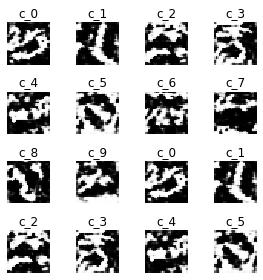

In [22]:
checkpoint_folder = 'baseline-checkpoints'
it_restore = None # use None to load the last checkpoint

print('For experiment {}:'.format(checkpoint_folder))
print('-'*10)
split.restore(it_restore=it_restore, checkpoint_folder=checkpoint_folder)

g.setup_ckpt(it_restore)
g.restore(it_restore=it_restore, checkpoint_folder=checkpoint_folder)

# Evaluate on the test dataset
print('\nBlack box on testing set:')
split.evaluate(split_training_params['test_dataset'])

print('Black box on G images:')
split.evaluate(generate_images(g, batch_size, noise_dim))
print()

# Generated images from G
print('Generated images from G:')
plot_images(g, batch_size, noise_dim)

## FGSM - Inf norm

For experiment fgsm-Inf-checkpoints:
----------
Restored latest checkpoint from fgsm-Inf-checkpoints\it_32\blackbox_checkpoint
Restored c_G to latest checkpoint from fgsm-Inf-checkpoints\it_32\c_generator_checkpoint

Black box on testing set:
Test Accuracy: 0.972 | Loss: 1.488

Black box on G images:
Test Accuracy: 1.000 | Loss: 1.461


Generated images from G:


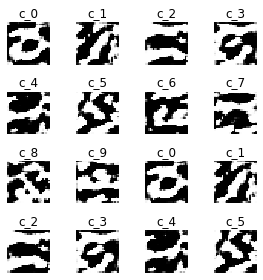

In [23]:
checkpoint_folder = 'fgsm-Inf-checkpoints'
it_restore = None # use None to load the last checkpoint

print('For experiment {}:'.format(checkpoint_folder))
print('-'*10)
split.restore(it_restore=it_restore, checkpoint_folder=checkpoint_folder)

g.setup_ckpt(it_restore)
g.restore(it_restore=it_restore, checkpoint_folder=checkpoint_folder)

# Evaluate on the test dataset
print('\nBlack box on testing set:')
split.evaluate(split_training_params['test_dataset'])

print('Black box on G images:')
split.evaluate(generate_images(g, batch_size, noise_dim))
print()

# Generated images from G
print('Generated images from G:')
plot_images(g, batch_size, noise_dim)

## FGSM - L1 norm

For experiment fgsm-L1-checkpoints:
----------
Restored latest checkpoint from fgsm-L1-checkpoints\it_32\blackbox_checkpoint
Restored c_G to latest checkpoint from fgsm-L1-checkpoints\it_32\c_generator_checkpoint

Black box on testing set:
Test Accuracy: 0.973 | Loss: 1.487

Black box on G images:
Test Accuracy: 0.800 | Loss: 1.661


Generated images from G:


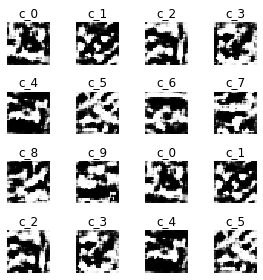

In [24]:
checkpoint_folder = 'fgsm-L1-checkpoints'
it_restore = None # use None to load the last checkpoint

print('For experiment {}:'.format(checkpoint_folder))
print('-'*10)
split.restore(it_restore=it_restore, checkpoint_folder=checkpoint_folder)

g.setup_ckpt(it_restore)
g.restore(it_restore=it_restore, checkpoint_folder=checkpoint_folder)

# Evaluate on the test dataset
print('\nBlack box on testing set:')
split.evaluate(split_training_params['test_dataset'])

print('Black box on G images:')
split.evaluate(generate_images(g, batch_size, noise_dim))
print()

# Generated images from G
print('Generated images from G:')
plot_images(g, batch_size, noise_dim)

## uGAN

For experiment ugan-checkpoints:
----------
Restored latest checkpoint from ugan-checkpoints\it_32\blackbox_checkpoint
Restored c_G to latest checkpoint from ugan-checkpoints\it_32\c_generator_checkpoint

Black box on testing set:
Test Accuracy: 0.974 | Loss: 1.486

Black box on G images:
Test Accuracy: 0.700 | Loss: 1.759


Generated images from G:


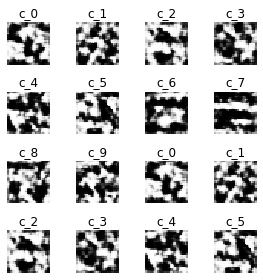

In [25]:
checkpoint_folder = 'ugan-checkpoints'
it_restore = None # use None to load the last checkpoint

print('For experiment {}:'.format(checkpoint_folder))
print('-'*10)
split.restore(it_restore=it_restore, checkpoint_folder=checkpoint_folder)

g.setup_ckpt(it_restore)
g.restore(it_restore=it_restore, checkpoint_folder=checkpoint_folder)

# Evaluate on the test dataset
print('\nBlack box on testing set:')
split.evaluate(split_training_params['test_dataset'])

print('Black box on G images:')
split.evaluate(generate_images(g, batch_size, noise_dim))
print()

# Generated images from G
print('Generated images from G:')
plot_images(g, batch_size, noise_dim)